# Workflow Debugging

(806, 20)
Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 3.9553 - accuracy: 0.5404

2022-04-21 10:00:49.074762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 7ms/step - loss: 3.9587 - accuracy: 0.5496
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 1.8100 - accuracy: 0.6631
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 1.0684 - accuracy: 0.7057
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.7031 - accuracy: 0.7589
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6741 - accuracy: 0.7482
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6945 - accuracy: 0.7642
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6153 - accuracy: 0.7872
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6239 - accuracy: 0.7819
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6522 - accuracy: 0.7855
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6159 - accuracy: 0.7979
Epoch 11/100
18/18 [=

18/18 [==============================] - 0s 7ms/step - loss: 0.2507 - accuracy: 0.9078
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2410 - accuracy: 0.9131
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2102 - accuracy: 0.9309
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2038 - accuracy: 0.9184
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1888 - accuracy: 0.9309
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2258 - accuracy: 0.9113
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1792 - accuracy: 0.9379
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2148 - accuracy: 0.9131
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2462 - accuracy: 0.9043
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2700 - accuracy: 0.8989
Epoch 93/100


2022-04-21 10:01:01.127295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on test data: 0.8181818723678589% 
 Error on test data: 0.1818181276321411
len(y_predicted) 242
dj_41  predicted:  0  should be:  5  diff:  2474.777038506182
dj_31  predicted:  0  should be:  5  diff:  3254.1435054104372
portfoliovqe_16  predicted:  1  should be:  0  diff:  2336.649282111426
graphstate_35  predicted:  0  should be:  5  diff:  1380.038304685525
graphstate_24  predicted:  0  should be:  5  diff:  1094.704581609125
dj_44  predicted:  0  should be:  5  diff:  1948.1418425480097
wstate_114  predicted:  0  should be:  5  diff:  203.55455340678964
ghz_130  predicted:  5  should be:  0  diff:  0
wstate_87  predicted:  0  should be:  5  diff:  1048.635571445066
portfoliovqe_15  predicted:  1  should be:  0  diff:  2083.4504204772547
ae_11

2022-04-21 10:01:01.358744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  predicted:  1  should be:  2  diff:  7124.443787240572
dj_37  predicted:  0  should be:  5  diff:  3451.5090657945434
graphstate_12  predicted:  2  should be:  1  diff:  997826.3558139473
wstate_11  predicted:  5  should be:  2  diff:  724.576597932265
wstate_90  predicted:  0  should be:  5  diff:  888.21708548999
dj_34  predicted:  0  should be:  5  diff:  2269.5886336651524
hhl_5  predicted:  2  should be:  5  diff:  1892.807297438867
portfoliovqe_14  predicted:  1  should be:  0  diff:  3740.309334837075
wstate_115  predicted:  0  should be:  5  diff:  248.61815994250264
dj_42  predicted:  0  should be:  5  diff:  2391.073601069473
wstate_89  predicted:  0  should be:  5  diff:  931.8448216252873
qpeinexact_19  predicted:  0  should be:  1  diff:  166.60714365360036
wstate_110  predicted:  0  should be:  5  diff:  124.61663447205956
dj_11  predicted:  5  should be:  2  diff:  1513.6113419326534
vqe_12  predicted:  2  should be:  0  diff:  989024.2123596653
wstate_2  predicted:  0

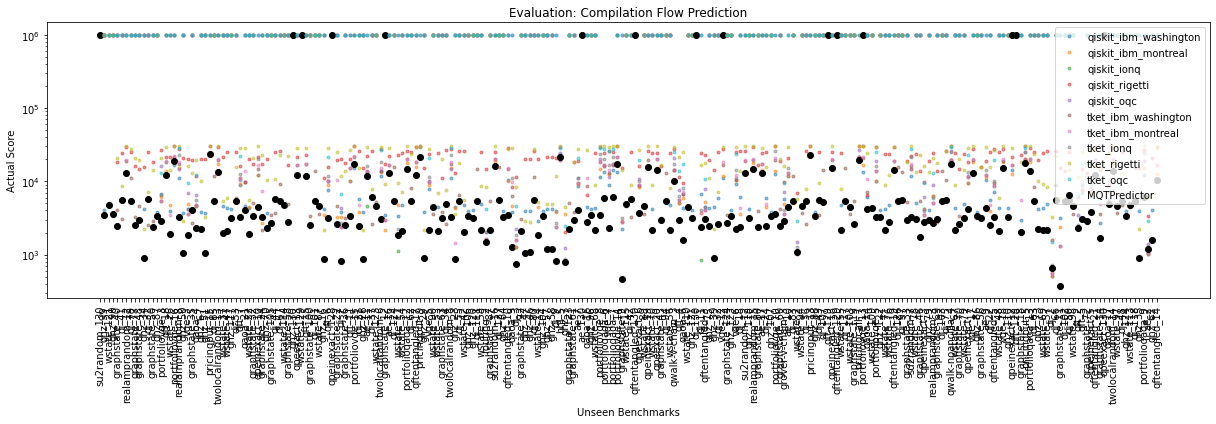

In [19]:
from evaluator.eval import extract_training_data_from_json, train_simple_ml_model
import numpy as np
training_data, names_list, scores_list = extract_training_data_from_json("json_data_big_server.json")
#print(names_list)
X, y = zip(*training_data)
X = np.array(X)
y = np.array(y)
non_zero_indices = []
for i in range(len(X[0])):
    if sum(X[:,i]) > 0:
        non_zero_indices.append(i)
X = X[:, non_zero_indices]
print(X.shape)
train_simple_ml_model(X,y, True, names_list, scores_list)

In [20]:
from sklearn.model_selection import train_test_split
from evaluator.src import utils
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

openqasm_gates_list = utils.get_openqasm_gates()
res = [openqasm_gates_list[i] for i in range(0, len(openqasm_gates_list))]
res.append("num_qubits")


features = np.sort(np.array(res))
features = features[non_zero_indices]
print(features)


['ccx' 'cp' 'cry' 'cu' 'cu1' 'cx' 'cz' 'h' 'num_qubits' 'p' 'rx' 'ry' 'rz'
 'rzz' 'swap' 'u' 'u1' 'u2' 'u3' 'x']


1 0.8909774436090225
2 0.8909774436090225
3 0.9060150375939849
4 0.924812030075188
5 0.9172932330827067
6 0.9323308270676691
7 0.9473684210526315
8 0.9285714285714286
9 0.9323308270676691


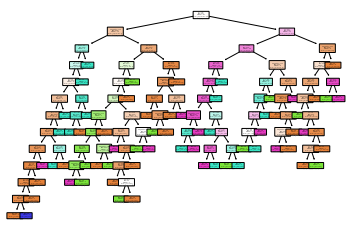

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

#Create a Gaussian Classifier
for i in range(1,10,1):
    clf=RandomForestClassifier(n_estimators=i)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)

    y_pred=clf.predict(X_test)
    print(i, np.mean(y_pred == y_test))
    plot_tree(clf.estimators_[0], 
          feature_names=features,
          class_names=utils.get_machines(),
          filled=True, impurity=True, 
          rounded=True);

In [22]:
from sklearn.svm import SVC
#Create a Gaussian Classifier

clf=SVC(kernel="linear")

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))

0.8533834586466166


In [23]:
from sklearn.naive_bayes import GaussianNB

clf=GaussianNB()

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))

0.7105263157894737


In [27]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
#Create a Gaussian Classifier


clf = AdaBoostClassifier(n_estimators=10)
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))

0.5676691729323309


0.9135338345864662


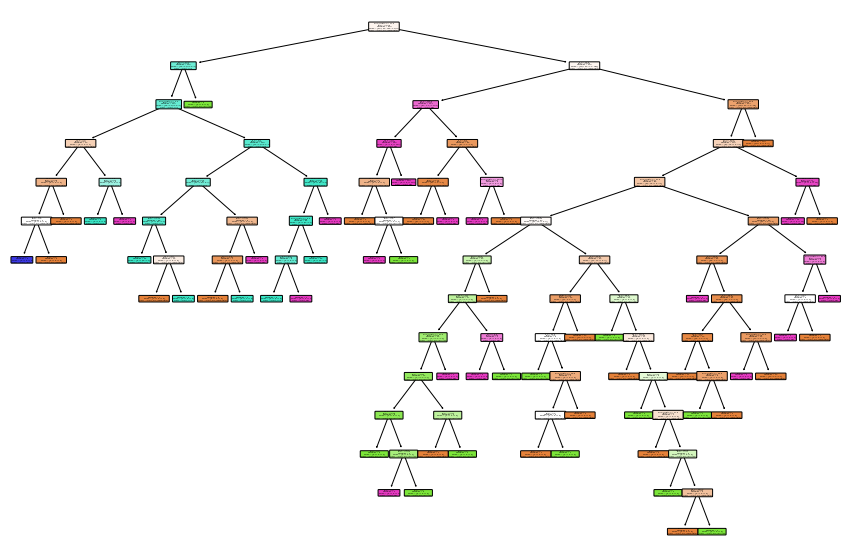

In [25]:

import matplotlib.pyplot as plt
from evaluator.src import utils
from sklearn.tree import plot_tree
from sklearn import tree


clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.predict(X_test)

fig = plt.figure(figsize=(15, 10))

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))
plot_tree(clf, 
          feature_names=features,
          class_names=utils.get_machines(),
          filled=True, impurity=True, 
          rounded=True);
plt.savefig("DecisionTreeClassifier.png", dpi=600)

# Debugging

In [1]:
from evaluator import eval
from evaluator.src import utils, pytket_plugin, qiskit_plugin
import pytest
from pytket.extensions.qiskit import qiskit_to_tk
from mqt.bench import get_one_benchmark
from pytket import circuit, OpType

In [64]:
1-4.561e-2




0.95439